# Box office predictions
* Complete machine learning workflow. Exploratory analysis -> Data cleaning -> Feature engineering -> Model training
* Interpretation of results

Project is using predictive modelling on data gathered from IMDB up to 2014 to predict box office profits for movies released in 2015 and 2016.

## Objectives
* In general, is the profit of a movie correlated with its user score on IMDb? 
* How about its number of votes?
* What do these correlations tell you?
* Using the data from 2014 and earlier, can you predict the profit of movies released in 2015 and 2016?
* Let's say that you were able to show movies pre-release to a representative focus group, which accurately anticipates the score of a movie (but not its overall popularity), can you improve your model?

### Data
* One table *box_office_predictions.csv* containing data on 6000 movies from IMDb, released in 2016 and earlier.

#### Data dictionary
* **budget** - Total cost of the film
* **country** - country of release
* **director** - Film director's name
* **genre** - Primary genre category
* **gross** - Total gross revenue
* **name** - Name and year of the film
* **rating** - MPAA rating of the film
* **runtime** - Length of the film in mins
* **score** - User score on IMDb
* **star** - Lead actor of the film
* **studio** - Studio that produced the film
* **votes** - Number of user ratings on IMDb

### Loading libraries

In [1]:
# Python 3 compatibility
from __future__ import print_function

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 20)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook instead of popup

# Seaborn for nicer plots
import seaborn as sns

# Cleaner output
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
df = pd.read_csv('../data/box_office_predictions.csv')

## Exploratory data analysis
### Basic checks on the dataset
* Shape
* Data types
* Categorical variables
* Numeric distributions
* Dataset statistics
* Statistics including categorical features
* First rows of the dataset


In [3]:
df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes
0,237000000.0,UK,James Cameron,Action,760507625.0,Avatar (2009),PG-13,162,7.8,Sam Worthington,Twentieth Century Fox Film Corporation,958400
1,200000000.0,USA,James Cameron,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551
2,150000000.0,USA,Colin Trevorrow,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,Chris Pratt,Universal Pictures,470625
3,220000000.0,USA,Joss Whedon,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,Marvel Studios,1069292
4,185000000.0,USA,Christopher Nolan,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853


* The dataset has a mix of numeric and categorical features.
* There are variables for budget and gross revenue, but no variable for profit or roi. These will need creating later.
* The "name" feature also includes the year the film was released. We can extract this information to create an age of film feature.

In [4]:
# 12 features for 6000 observations
df.shape

(6000, 12)

In [5]:
# All features
df.dtypes

budget      float64
country      object
director     object
genre        object
gross       float64
name         object
rating       object
runtime       int64
score       float64
star         object
studio       object
votes         int64
dtype: object

In [6]:
# Only categorical
df.dtypes[df.dtypes == 'object']

country     object
director    object
genre       object
name        object
rating      object
star        object
studio      object
dtype: object

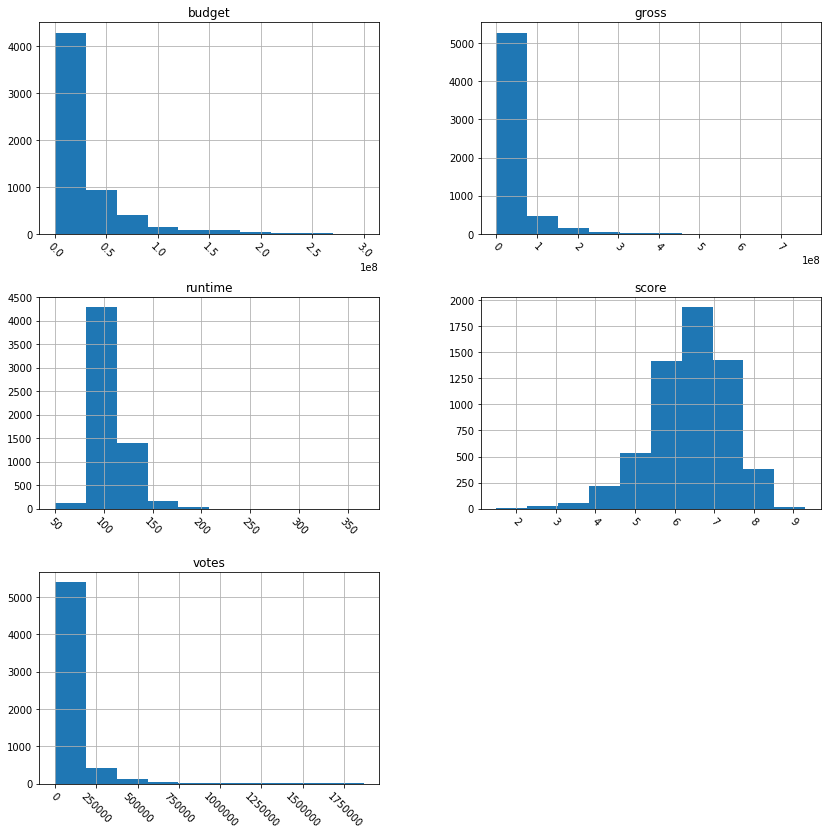

In [7]:
# Plot histogram grid
df.hist(figsize=[14,14], xrot=315)
# Clear the text "residue"
plt.show()

#### Assumptions
* Looking at the budget - possibly in millions
* Score looks normally distributes which is usual with things involving human population
* Looks like most movies have very few votes
* Most movies are about 110 minutes in length which is consistent with research on this here https://www.slashfilm.com/by-the-numbers-the-length-of-feature-films/2/ and here https://www.reddit.com/r/dataisbeautiful/comments/6vnwa9/average_movie_length_by_country_source_imdb_of/
* Gross is not clear, seems to be too small to be in millions. Will need further looking into

In [8]:
df.describe()

,budget,gross,runtime,score,votes
count,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6.000000e+03
mean,2.469918e+07,3.341635e+07,106.587000,6.386383,7.188537e+04
std,3.721710e+07,5.735205e+07,18.026885,0.994921,1.308033e+05
min,0.000000e+00,4.410000e+02,50.000000,1.500000,2.700000e+01
25%,0.000000e+00,1.527796e+06,95.000000,5.800000,7.791750e+03
50%,1.100000e+07,1.229897e+07,102.000000,6.500000,2.660150e+04
75%,3.262500e+07,4.007256e+07,115.000000,7.100000,7.677475e+04
max,3.000000e+08,7.605076e+08,366.000000,9.300000,1.868308e+06


Based on the summary statistics, we see that some films have a budget of 0 in the dataset. Here are a few examples:

In [9]:
# Examples of films with 0 budget
df[df.budget == 0].head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes
56,0.0,UK,David Yates,Adventure,295983305.0,Harry Potter and the Deathly Hallows: Part 1 (...,PG-13,146,7.7,Daniel Radcliffe,Warner Bros.,370003
207,0.0,USA,Walt Becker,Action,168273550.0,Wild Hogs (2007),PG-13,100,5.9,Tim Allen,Touchstone Pictures,104657
431,0.0,USA,John G. Avildsen,Action,115103979.0,The Karate Kid Part II (1986),PG,113,5.9,Pat Morita,Columbia Pictures Corporation,58596
553,0.0,USA,Nora Ephron,Comedy,95318203.0,Michael (1996),PG,105,5.7,John Travolta,Turner Pictures (I),36553
592,0.0,USA,Tyler Perry,Comedy,90485233.0,Madea Goes to Jail (2009),PG-13,103,4.3,Tyler Perry,"Tyler Perry Company, The",10095


These are most likely missing values or data collection errors. But since our goal is to investigate profitability of films, we cannot study films with missing budget values.

To improve the analysis in the future, we'd want to troubleshoot our data source to find out if we can get the budgets of those films. For now, we'll remove those films.

In [10]:
# Remove films with "0" budget
df = df.loc[df.budget > 0,:]

In [11]:
df.describe(include=['object'])

,country,director,genre,name,rating,star,studio
count,4089,4089,4089,4089,4089,4089,4089
unique,42,1757,16,4089,8,1501,1232
top,USA,Woody Allen,Comedy,Nadine (1987),R,Nicolas Cage,Universal Pictures
freq,3275,26,1136,1,2001,36,235


#### Insights
* There seems to be no missing values for categorical features
* Most movies are US comedies, however there are 52 counties present in the dataset and 17 genres
* some categorical features have a large number of unique classes relative to the number of total observations. 

There are 1232 unique studios in the dataset of 4089 observations (after filtering for non-zero budget). This will most likely lead to sparse classes, so we'll want to address this during feature engineering.

In [12]:
# Reverse sort studios by total number of films
df.studio.value_counts().tail()

Applied Action           1
Santa Monica Holdings    1
Seraphim Films           1
George Films             1
SBS Productions          1
Name: studio, dtype: int64

Compare that to the top studios in the dataset, and we can see that it will be useful to combine low-frequency studios into tiered classes

In [13]:
# Top studios by total number of films
df.studio.value_counts().head()

Universal Pictures                        235
Warner Bros.                              231
Paramount Pictures                        197
Twentieth Century Fox Film Corporation    148
New Line Cinema                           123
Name: studio, dtype: int64

### Data cleaning considerations
* Check for duplicates
* Check for missing values

#### Check for duplicates

In [14]:
# check for duplicates by movie name
df['name'].value_counts().head()

Nadine (1987)                      1
La casa de los espíritus (1993)    1
La Bamba (1987)                    1
Intersection (1994)                1
Car 54, Where Are You? (1994)      1
Name: name, dtype: int64

it seems there are no duplicates in the dataset

#### Find missing values

In [15]:
# Find missing data in categorical features
df.select_dtypes(include=['object']).isnull().sum()

country     0
director    0
genre       0
name        0
rating      0
star        0
studio      0
dtype: int64

Seems no data is missing here

In [16]:
# Display number of missing values by feature (numeric)
df.select_dtypes(exclude=['object']).isnull().sum()

budget     0
gross      0
runtime    0
score      0
votes      0
dtype: int64

No missing values here as well

## Feature engineering

Creating target variable

In [17]:
df['profit'] = df.gross - df.budget

### Combine sparse classes into tiers

There are other valid ways of combining classes. For example, you could try combining studios based on their average production budget (as a proxy for studio size). We will combine them based on their total number of films in the dataset.

In [18]:
# Number of films from each studio
studio_counts = df.studio.value_counts()

# Tiers for sparser studios
one = studio_counts[studio_counts <= 1].index
three_five = studio_counts[(studio_counts > 1) & (studio_counts <= 3)].index
five_ten = studio_counts[(studio_counts > 3) & (studio_counts <= 5)].index
ten_plus = studio_counts[(studio_counts > 5) & (studio_counts <= 10)].index

# Combine sparse studios
df['studio'].replace(one, '1', inplace=True)
df['studio'].replace(three_five, '3-5', inplace=True)
df['studio'].replace(five_ten, '5-10', inplace=True)
df['studio'].replace(ten_plus, '10+', inplace=True)

In [19]:
# Same with stars
# Number of films from each star
star_counts = df.star.value_counts()

# Tiers for sparser stars
one = star_counts[star_counts <= 1].index
three_five = star_counts[(star_counts > 1) & (star_counts <= 3)].index
five_ten = star_counts[(star_counts > 3) & (star_counts <= 5)].index
ten_plus = star_counts[(star_counts > 5) & (star_counts <= 10)].index

# Combine sparse stars
df['star'].replace(one, '1', inplace=True)
df['star'].replace(three_five, '3-5', inplace=True)
df['star'].replace(five_ten, '5-10', inplace=True)
df['star'].replace(ten_plus, '10+', inplace=True)

In [20]:
# Number of films from each director
director_counts = df.director.value_counts()

# Tiers for sparser directors
one = director_counts[director_counts <= 1].index
three_five = director_counts[(director_counts > 1) & (director_counts <= 3)].index
five_ten = director_counts[(director_counts > 3) & (director_counts <= 5)].index
ten_plus = director_counts[(director_counts > 5) & (director_counts <= 10)].index

# Combine sparse directors
df['director'].replace(one, '1', inplace=True)
df['director'].replace(three_five, '3-5', inplace=True)
df['director'].replace(five_ten, '5-10', inplace=True)
df['director'].replace(ten_plus, '10+', inplace=True)

### Combining countries

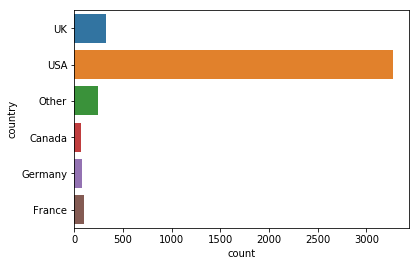

In [21]:
# it looks like movies mainly come from top 5 countries in this dataset
#Number of films from each country
country_counts = df.country.value_counts()

# New class frequencies
df.country.value_counts()
top_5_list = df.country.value_counts().index[:5]
df.loc[~df.country.isin(top_5_list), 'country'] = 'Other'
sns.countplot(y='country', data=df)

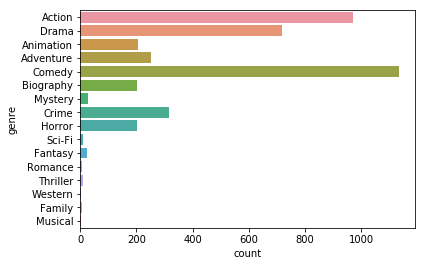

In [22]:
sns.countplot(y='genre', data=df)

It looks like we have 8 top genres, let's combine sparse genres into Other

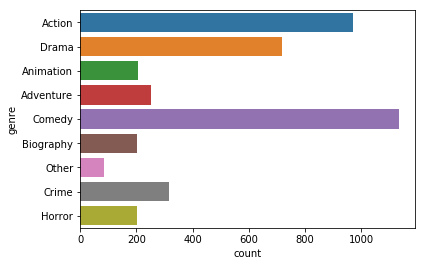

In [23]:
# top 8 genres
top_8_list = df.genre.value_counts().index[:8]
df.loc[~df.genre.isin(top_8_list), 'genre'] = 'Other'
sns.countplot(y='genre', data=df)

*rating* feature has an issue where Unrated films have different labels:

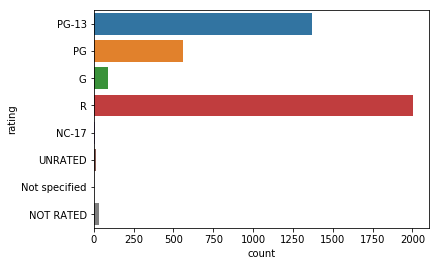

In [24]:
sns.countplot(y='rating', data=df)

In [25]:
# Fix "unrated" labels
df['rating'].replace(['NOT RATED', 'UNRATED', 'Not specified'], 'NR', inplace=True)

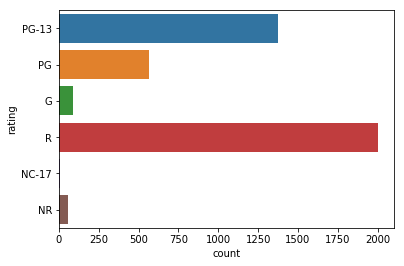

In [26]:
sns.countplot(y='rating', data=df)

Finally, we'll create an age feature for the film. 

Note: We will set "today" to 2014 to imitate an analysis performed in 2014 to predict films in 2015 and 2016.

In [27]:
def extract_age(s, today=2014):
    return today - int( s[-5:-1] )

In [28]:
# Create "age" feature
df['age'] = df.name.apply(extract_age)

In [29]:
df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes,profit,age
0,237000000.0,UK,5-10,Action,760507625.0,Avatar (2009),PG-13,162,7.8,3-5,Twentieth Century Fox Film Corporation,958400,523507625.0,5
1,200000000.0,USA,5-10,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551,458672302.0,17
2,150000000.0,USA,3-5,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,3-5,Universal Pictures,470625,502270625.0,-1
3,220000000.0,USA,3-5,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,10+,1069292,403357910.0,2
4,185000000.0,USA,10+,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853,349858444.0,6


## Correlations

* Is the profit of a movie correlated with it's user score?
 * There is very low positive correlation, we can assume that these two features are not correlated
* How about its number of votes?
 * Votes have strong positive correlation with gross profit
* What do these correlations tell us?
 * Gross profit is directly dependent on how many people watched the movie. It looks as movie recieves more ratings as more people watch it but the score people give does not depend on the profit and vice versa.

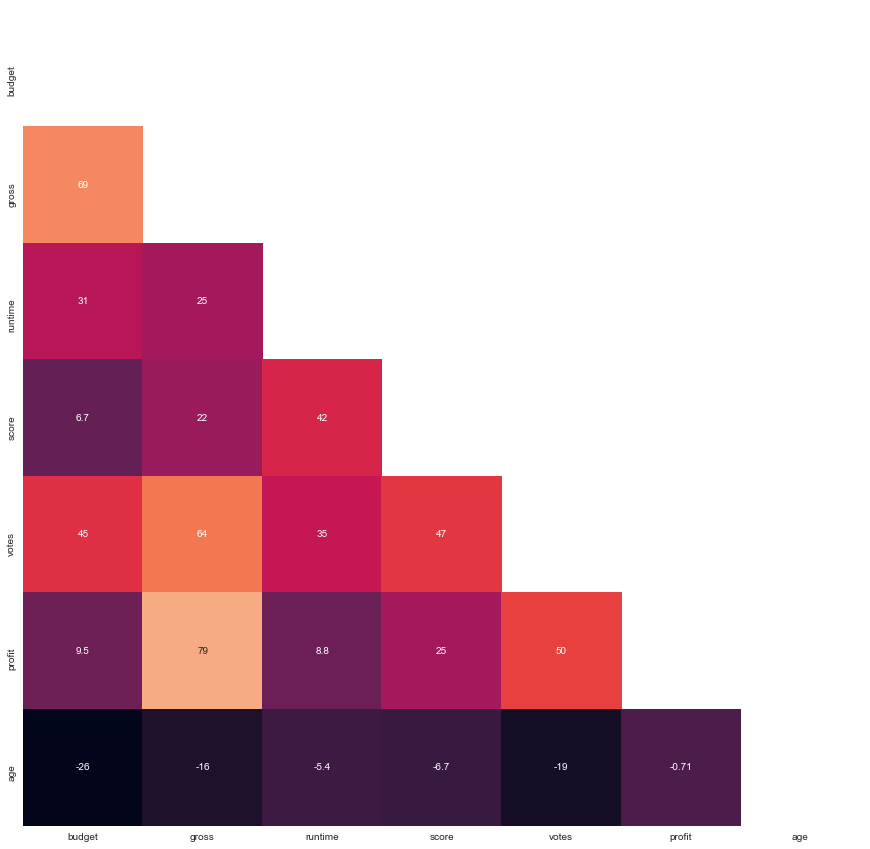

In [30]:
# Calculate correlations:
correlations = df.corr()

### SNS plot theme
# Change color scheme
sns.set_style('white')
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Make the figsize
plt.figure(figsize=(15,15))

# Plot heatmap of correlations
sns.heatmap(correlations*100, annot=True, mask=mask, cbar=False)

## Machine learning

Next, we will prepare the data for machine learning by creating an analytical base table. We will drop name columns because it's basically an index column and the gross, votes, and score features because we do not know them at the time.

In [45]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [32]:
# Create analytical base table (ABT)
abt = pd.get_dummies ( df.drop(['name', 'gross', 'votes', 'score'], axis=1) )

We'll split the data based on date of training data (2014 and earlier) and test data (2015, 2016)

In [33]:
# Train / Test split based on date of training data (2014 and earlier) and test data (2015, 2016)
train = abt[abt.age >= 0]
test = abt[abt.age <= 0]

y_train = train.profit
X_train = train.drop(['profit'], axis=1)

y_test = test.profit
X_test = test.drop(['profit'], axis=1)

We will try a basic random forest

In [34]:
# Train a basic random forest model
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train, y_train)

# Make prediction on test set
pred = rf.predict(X_test)

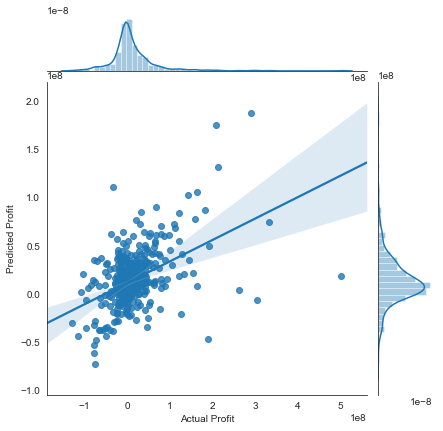

In [35]:
sns.jointplot(y_test, pred, kind='reg')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.show()

In [36]:
# scores
print('R^2 score: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R^2 score:  0.22029037231625237
MAE:  29684720.822394677


As you can see in the plot, the very model actually does a pretty good job predicting the profitability of films based on the limited data we have and out of the box model.

Whether this model performance is "good enough" will depend on the use-case. For example, in a betting market, this model would already give a formidable edge.

Finally, we'll plot the feature importances.

In [37]:
# Helper function for plotting feature importances
def plot_feature_importances(columns, feature_importances, show_top_n=10):
    feats = dict( zip(columns, feature_importances) )
    imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    imp.sort_values(by='Gini-importance').tail(show_top_n).plot(kind='barh', figsize=(8,8))
    plt.show()

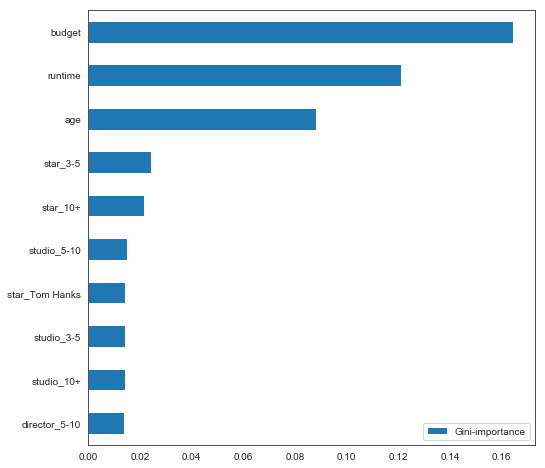

In [38]:
plot_feature_importances(X_train.columns, rf.feature_importances_)

As a whole, the budget feature was the most important in our model. But earlier, we found that budget and profit were not correlated?

This seems contradictory, but the answer has to do with the difference between first-order correlations and a full model. Earlier, we were looking at the correlation between budget and profit at an aggregate level.

But now that we've built a model, we can look at the affect of budget while controlling for all the other input features as well.

## Machine Learning with Pre-Screen
Next, we'll create a new analytical base table for the scenario where we're able to collect an accurate score input based on film pre-screenings.

In [39]:
# Create new analytical base table (ABT)
abt_ps = pd.get_dummies ( df.drop(['name', 'gross', 'votes'], axis=1) )

In [40]:
train = abt_ps[abt_ps.age >= 0]
test = abt_ps[abt_ps.age <= 0]

y_train = train.profit
X_train = train.drop(['profit'], axis=1)

y_test = test.profit
X_test = test.drop(['profit'], axis=1)

In [41]:
# Train a basic random forest model
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train, y_train)

# Make prediction on test set
pred = rf.predict(X_test)

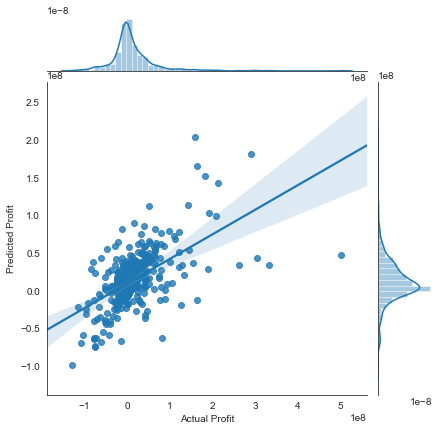

In [42]:
sns.jointplot(y_test, pred, kind='reg')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.show()

In [43]:
# scores
print('R^2 score: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R^2 score:  0.3371924664808582
MAE:  25972965.048558757


Including the score feature improves our model's performance substantially. We should make effort to collect this data for any film we'd like to predict.

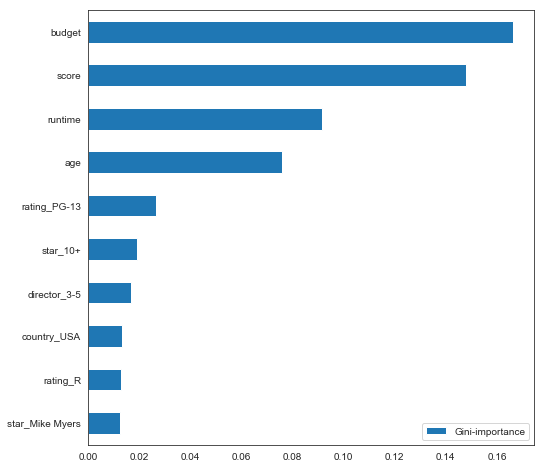

In [44]:
plot_feature_importances(X_train.columns, rf.feature_importances_)

The score turns out to be the second important feature after the budget